In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

from scipy import stats as sstats
import numpy as np
import pylab as pl

# setting parameters for default matplotlib plots
%matplotlib inline
pl.rcParams['savefig.dpi'] = 300 # dpi for most publications
pl.rcParams['xtick.labelsize'] = 7
pl.rcParams['ytick.labelsize'] = 7
pl.rcParams['axes.labelsize'] = 7

# needs to find the library of functions
sys.path.append('../../../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'selectivity'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'update_selectivity', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'update_selectivity_40suc_10sho_constrained', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)


In [5]:
folder = './autorestore/preprocessing/'
for var in ('time_ax', 'events', 'cycles',
            'CYCLE_START', 'ANALYSIS_WINDOW',
            'US_START', 'US_DURATION',
            'is_rewardt', 'is_shockt',
            'is_coyotet', 'is_femalet',
            'is_blastt',
            'licks', 'mean_image', 'contours'): 
    exec('%s = ut.load_variable(\'%s\', folder=\'%s\')'%(var, var, folder))

In [6]:
print CYCLE_START

-6


In [7]:
from scipy import stats as sstats

In [8]:
def update_selectivity(selectivity, trial_types, between_what, and_what, append='', append_trial='t'):

    for t in trial_types:

        # this one selects which trials to consider
        which_cycles = eval('is_%s'%(t+append_trial))
        print sum(which_cycles)
            
        if not np.any(which_cycles):
            continue
        
        selectivity[t+append] = ut.compute_selectivity(time_ax, events, cycles[which_cycles],
                                                       between_what, and_what)

In [9]:
def update_selectivity_40suc_10sho_constrained(selectivity_constrained, trial_types, between_what, and_what, append='', append_trial='t'):

    for t in trial_types:

        # this one selects which trials to consider
        which_cycles = eval('is_%s'%(t+append_trial))
        if t == 'reward':
            is_first_40_rewardt = np.r_[[False]*len(which_cycles)]
            trues = [i for i, x in enumerate(which_cycles) if x == True]
            trues = trues[0:40]
            for i in range(len(trues)):
                is_first_40_rewardt[trues[i]] = True
            which_cycles = is_first_40_rewardt
            
            print sum(which_cycles)
                
        elif t == 'shock':
            is_first_10_shockt = np.r_[[False]*len(which_cycles)]
            trues = [i for i, x in enumerate(which_cycles) if x == True]
            trues = trues[0:10]
            for i in range(len(trues)):
                is_first_10_shockt[trues[i]] = True
            which_cycles = is_first_10_shockt

            print sum(which_cycles)
            
        if not np.any(which_cycles):
            continue
        
        selectivity_constrained[t+append] = ut.compute_selectivity(time_ax, events, cycles[which_cycles],
                                                       between_what, and_what)

In [10]:
# CHOOSE WHAT PERIOD DEFINES THE CS WITH REF. TO CYCLE START
baseline_timeframe = (US_START-CYCLE_START-ANALYSIS_WINDOW, US_START-CYCLE_START)
us_timeframe = (US_START-CYCLE_START, US_START+ANALYSIS_WINDOW-CYCLE_START)
us_late_timeframe = (US_START+ANALYSIS_WINDOW-CYCLE_START, US_START+US_DURATION-CYCLE_START+ANALYSIS_WINDOW)
pre_timeframe = (US_START-CYCLE_START-ANALYSIS_WINDOW-ANALYSIS_WINDOW, US_START-CYCLE_START-ANALYSIS_WINDOW)
fourSec_baseline_timeframe= (US_START-CYCLE_START-4, US_START-CYCLE_START)
fourSec_us_timeframe = (US_START-CYCLE_START, US_START+4-CYCLE_START)
fourSec_pre_timeframe = (US_START-CYCLE_START-8, US_START-CYCLE_START-4)

In [11]:
selectivity = {}

trial_types = np.r_[['shock', 'reward', 'coyote', 'female', 'blast', 'collected']]

# US
update_selectivity(selectivity, trial_types, us_timeframe, baseline_timeframe, '_us')
# US late
update_selectivity(selectivity, trial_types, us_late_timeframe, baseline_timeframe, '_late')
#pre-baseline
update_selectivity(selectivity, trial_types, pre_timeframe, baseline_timeframe, '_pre')
# 4s_US
update_selectivity(selectivity, trial_types, fourSec_us_timeframe, fourSec_baseline_timeframe, '_4s_us')
# 4s_pre-baseline
update_selectivity(selectivity, trial_types, fourSec_pre_timeframe, fourSec_baseline_timeframe, '_4s_pre')


10
40
10
40
10
40
10
40
10
40


In [12]:
selectivity_constrained = {}

trial_types = np.r_[['shock', 'reward', 'coyote', 'female', 'blast', 'collected']]

# US
update_selectivity_40suc_10sho_constrained(selectivity_constrained, trial_types, us_timeframe, baseline_timeframe, '_us')
# US late
update_selectivity_40suc_10sho_constrained(selectivity_constrained, trial_types, us_late_timeframe, baseline_timeframe, '_late')
#pre-baseline
update_selectivity_40suc_10sho_constrained(selectivity_constrained, trial_types, pre_timeframe, baseline_timeframe, '_pre')
# 4s_US
update_selectivity_40suc_10sho_constrained(selectivity_constrained, trial_types, fourSec_us_timeframe, fourSec_baseline_timeframe, '_4s_us')
# 4s_pre-baseline
update_selectivity_40suc_10sho_constrained(selectivity_constrained, trial_types, fourSec_pre_timeframe, fourSec_baseline_timeframe, '_4s_pre')


10
40
10
40
10
40
10
40
10
40


In [13]:
selectivity_constrained.keys

<function keys>

In [14]:
selectivity.keys()

['reward_4s_pre',
 'shock_us',
 'reward_late',
 'reward_4s_us',
 'shock_4s_pre',
 'shock_pre',
 'shock_4s_us',
 'reward_pre',
 'shock_late',
 'reward_us']

In [63]:
significance = 0.05

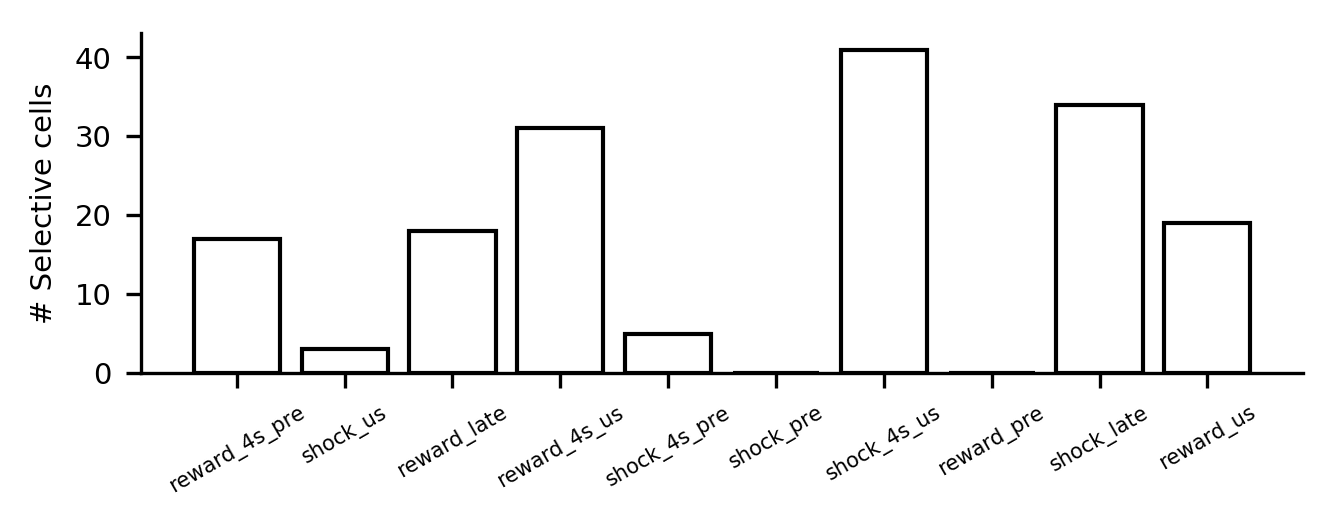

In [64]:
fig, ax = pl.subplots(1, 1, figsize=(5, 1.5))
values = [np.sum(ut.adjust_pvalues([s[1] for s in selectivity[t][:, 0]])<significance)
          for t in selectivity.keys()]
pt.plot_bars(values, ax=ax)
ax.set_xticks(range(len(selectivity)))
ax.set_xticklabels(selectivity.keys(), rotation=30, fontsize=5)
pt.nicer_plot(ax)
ax.set_ylabel('# Selective cells')
# ax.set_ylim(0, 0.7)

In [65]:
len(contours)

103

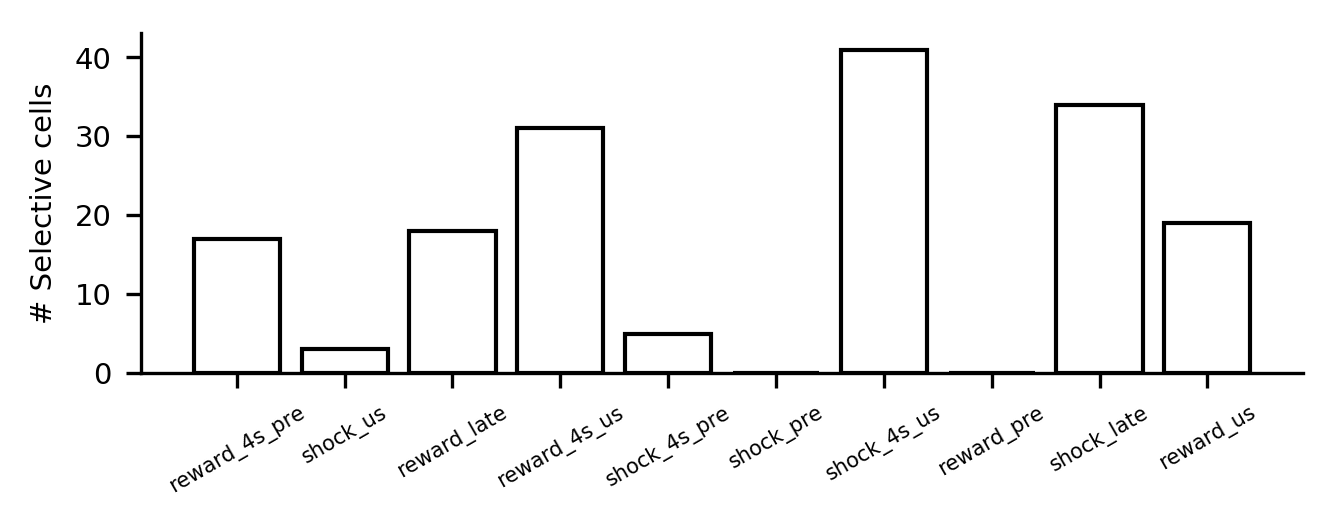

In [66]:
#significance = 0.05

fig, ax = pl.subplots(1, 1, figsize=(5, 1.5))
values = [np.sum(ut.adjust_pvalues([s[1] for s in selectivity_constrained[t][:, 0]])<significance)
          for t in selectivity_constrained.keys()]
pt.plot_bars(values, ax=ax)
ax.set_xticks(range(len(selectivity_constrained)))
ax.set_xticklabels(selectivity_constrained.keys(), rotation=30, fontsize=5)
pt.nicer_plot(ax)
ax.set_ylabel('# Selective cells')
# ax.set_ylim(0, 0.7)

In [67]:
pvals_female_4s_us = ut.multipletests([s[0][-1] for s in selectivity['female_4s_us']], method='fdr_bh')[1]
dirs_female_4s_us = np.r_[[s[1] for s in selectivity['female_4s_us']]]
pvals_coyote_4s_us = ut.multipletests([s[0][-1] for s in selectivity['coyote_4s_us']], method='fdr_bh')[1]
dirs_coyote_4s_us = np.r_[[s[1] for s in selectivity['coyote_4s_us']]]
pvals_sucrose_4s_us = ut.multipletests([s[0][-1] for s in selectivity['reward_4s_us']], method='fdr_bh')[1]
dirs_sucrose_4s_us = np.r_[[s[1] for s in selectivity['reward_4s_us']]]
pvals_shock_4s_us = ut.multipletests([s[0][-1] for s in selectivity['shock_4s_us']], method='fdr_bh')[1]
dirs_shock_4s_us = np.r_[[s[1] for s in selectivity['shock_4s_us']]]
pvals_blast_4s_us = ut.multipletests([s[0][-1] for s in selectivity['blast_4s_us']], method='fdr_bh')[1]
dirs_blast_4s_us = np.r_[[s[1] for s in selectivity['blast_4s_us']]]
pvals_collected_4s_us = ut.multipletests([s[0][-1] for s in selectivity['collected_4s_us']], method='fdr_bh')[1]
dirs_collected_4s_us = np.r_[[s[1] for s in selectivity['collected_4s_us']]]

In [68]:
sucrose_4s_us_up = (((pvals_sucrose_4s_us<significance)*(dirs_sucrose_4s_us>0))).sum()
shock_4s_us_up = (((pvals_shock_4s_us<significance)*(dirs_shock_4s_us>0))).sum()
sucrose_4s_us_dn = (((pvals_sucrose_4s_us<significance)*(dirs_sucrose_4s_us<0))).sum()
shock_4s_us_dn = (((pvals_shock_4s_us<significance)*(dirs_shock_4s_us<0))).sum()
sucrose_4s_us_up__shock_4s_us_up = (((pvals_sucrose_4s_us<significance)*(dirs_sucrose_4s_us>0))*((pvals_shock_4s_us<significance)*(dirs_shock_4s_us>0))).sum()
sucrose_4s_us_dn__shock_4s_us_dn = (((pvals_sucrose_4s_us<significance)*(dirs_sucrose_4s_us<0))*((pvals_shock_4s_us<significance)*(dirs_shock_4s_us<0))).sum()
sucrose_4s_us_up__shock_4s_us_dn = (((pvals_sucrose_4s_us<significance)*(dirs_sucrose_4s_us>0))*((pvals_shock_4s_us<significance)*(dirs_shock_4s_us<0))).sum()
sucrose_4s_us_dn__shock_4s_us_up = (((pvals_sucrose_4s_us<significance)*(dirs_sucrose_4s_us<0))*((pvals_shock_4s_us<significance)*(dirs_shock_4s_us>0))).sum()

#odors
female_4s_us_up = (((pvals_female_4s_us<significance)*(dirs_female_4s_us>0))).sum()
coyote_4s_us_up = (((pvals_coyote_4s_us<significance)*(dirs_coyote_4s_us>0))).sum()
female_4s_us_dn = (((pvals_female_4s_us<significance)*(dirs_female_4s_us<0))).sum()
coyote_4s_us_dn = (((pvals_coyote_4s_us<significance)*(dirs_coyote_4s_us<0))).sum()
female_4s_us_up__coyote_4s_us_up = (((pvals_female_4s_us<significance)*(dirs_female_4s_us>0))*((pvals_coyote_4s_us<significance)*(dirs_coyote_4s_us>0))).sum()
female_4s_us_dn__coyote_4s_us_dn = (((pvals_female_4s_us<significance)*(dirs_female_4s_us<0))*((pvals_coyote_4s_us<significance)*(dirs_coyote_4s_us<0))).sum()
female_4s_us_up__coyote_4s_us_dn = (((pvals_female_4s_us<significance)*(dirs_female_4s_us>0))*((pvals_coyote_4s_us<significance)*(dirs_coyote_4s_us<0))).sum()
female_4s_us_dn__coyote_4s_us_up = (((pvals_female_4s_us<significance)*(dirs_female_4s_us<0))*((pvals_coyote_4s_us<significance)*(dirs_coyote_4s_us>0))).sum()

#blasts
blast_4s_us_up = (((pvals_blast_4s_us<significance)*(dirs_blast_4s_us>0))).sum()
blast_4s_us_dn = (((pvals_blast_4s_us<significance)*(dirs_blast_4s_us<0))).sum()

In [69]:
print "There are", sucrose_4s_us_up, "cells that increase activity to sucrose."
print "There are", shock_4s_us_up, "cells that increase activity to shock."
print "There are", sucrose_4s_us_dn, "cells that decrease activity to sucrose."
print "There are", shock_4s_us_dn, "cells that decrease activity to shock."
print "There are", sucrose_4s_us_up__shock_4s_us_up, "cells that increase activity to both sucrose and shock."
print "There are", sucrose_4s_us_dn__shock_4s_us_dn, "cells that decrase activity to both sucrose and shock."
print "There are", sucrose_4s_us_up__shock_4s_us_dn, "cells that increase activity to sucrose and decrease to shock."
print "There are", sucrose_4s_us_dn__shock_4s_us_up, "cells that decrase activity to sucrose and increase shock."

There are 27 cells that increase activity to sucrose.
There are 38 cells that increase activity to shock.
There are 4 cells that decrease activity to sucrose.
There are 3 cells that decrease activity to shock.
There are 9 cells that increase activity to both sucrose and shock.
There are 0 cells that decrase activity to both sucrose and shock.
There are 0 cells that increase activity to sucrose and decrease to shock.
There are 2 cells that decrase activity to sucrose and increase shock.


In [ ]:
print "There are", female_4s_us_up, "cells that increase activity to female."
print "There are", coyote_4s_us_up, "cells that increase activity to coyote."
print "There are", female_4s_us_dn, "cells that decrease activity to female."
print "There are", coyote_4s_us_dn, "cells that decrease activity to coyote."
print "There are", female_4s_us_up__coyote_4s_us_up, "cells that increase activity to both female and coyote."
print "There are", female_4s_us_dn__coyote_4s_us_dn, "cells that decrase activity to both female and coyote."
print "There are", female_4s_us_up__coyote_4s_us_dn, "cells that increase activity to female and decrease to coyote."
print "There are", female_4s_us_dn__coyote_4s_us_up, "cells that decrase activity to female and increase coyote."

In [70]:
tuned_cells = {}
for k, v in selectivity.iteritems():
    corrected_ps = ut.adjust_pvalues([s[1] for s in selectivity[k][:, 0]])
    tuned_cells[k] = [np.where((corrected_ps<significance)*([s>0 for s in v[:, 1]]))[0],
                      np.where((corrected_ps<significance)*([s<0 for s in v[:, 1]]))[0],]

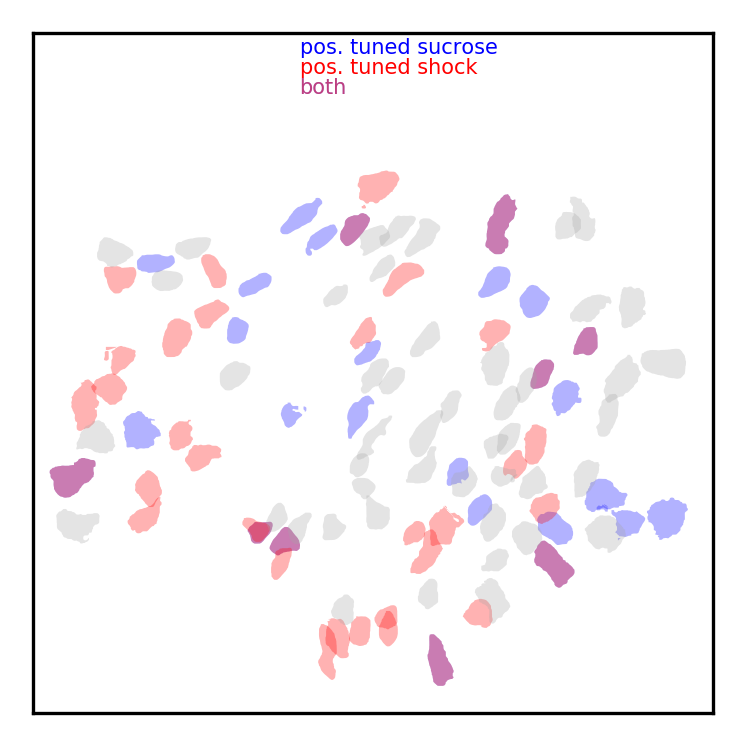

In [71]:
list_of_cells = [tuned_cells['reward_4s_us'][0], tuned_cells['shock_4s_us'][0]]
rest_of_cells = np.delete(range(events.shape[1]), np.concatenate(list_of_cells))
list_of_cells.append(rest_of_cells)

fig, ax = pl.subplots(1, 1, figsize=(3, 3))
pt.plot_rois(mean_image, contours,
             list_of_cells,
             colors=['b', 'r', '0.65'],
             ax=ax
            )
ax.set_xticks(())
ax.set_yticks(())
ax.text(200, 15, 'pos. tuned sucrose', color='b', fontsize=5)
ax.text(200, 30, 'pos. tuned shock', color='r', fontsize=5)
ax.text(200, 45, 'both', color='b', fontsize=5, alpha=0.5)
ax.text(200, 45, 'both', color='r', fontsize=5, alpha=0.5)

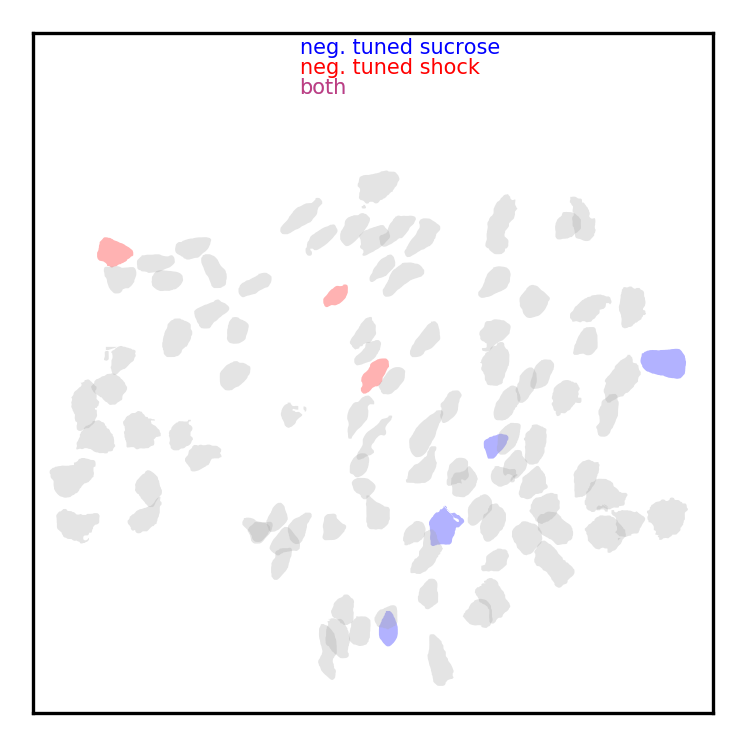

In [72]:
list_of_cells = [tuned_cells['reward_4s_us'][1], tuned_cells['shock_4s_us'][1]]
rest_of_cells = np.delete(range(events.shape[1]), np.concatenate(list_of_cells))
list_of_cells.append(rest_of_cells)

fig, ax = pl.subplots(1, 1, figsize=(3, 3))
pt.plot_rois(mean_image, contours,
             list_of_cells,
             colors=['b', 'r', '0.65'],
             ax=ax
            )
ax.set_xticks(())
ax.set_yticks(())
ax.text(200, 15, 'neg. tuned sucrose', color='b', fontsize=5)
ax.text(200, 30, 'neg. tuned shock', color='r', fontsize=5)
ax.text(200, 45, 'both', color='b', fontsize=5, alpha=0.5)
ax.text(200, 45, 'both', color='r', fontsize=5, alpha=0.5)

In [ ]:
list_of_cells = [tuned_cells['female_4s_us'][0], tuned_cells['coyote_4s_us'][0]]
rest_of_cells = np.delete(range(events.shape[1]), np.concatenate(list_of_cells))
list_of_cells.append(rest_of_cells)

fig, ax = pl.subplots(1, 1, figsize=(3, 3))
pt.plot_rois(mean_image, contours,
             list_of_cells,
             colors=['darkorange', 'b', '0.65'],
             ax=ax
            )
ax.set_xticks(())
ax.set_yticks(())
ax.text(200, 15, 'pos. tuned female', color='darkorange', fontsize=5)
ax.text(200, 30, 'pos. tuned coyote', color='b', fontsize=5)
ax.text(200, 45, 'both', color='darkorange', fontsize=5, alpha=0.5)
ax.text(200, 45, 'both', color='b', fontsize=5, alpha=0.5)

In [ ]:
list_of_cells = [tuned_cells['female_4s_us'][1], tuned_cells['coyote_4s_us'][1]]
rest_of_cells = np.delete(range(events.shape[1]), np.concatenate(list_of_cells))
list_of_cells.append(rest_of_cells)

fig, ax = pl.subplots(1, 1, figsize=(3, 3))
pt.plot_rois(mean_image, contours,
             list_of_cells,
             colors=['darkorange', 'b', '0.65'],
             ax=ax
            )
ax.set_xticks(())
ax.set_yticks(())
ax.text(200, 15, 'neg. tuned female', color='darkorange', fontsize=5)
ax.text(200, 30, 'nge. tuned coyote', color='b', fontsize=5)
ax.text(200, 45, 'both', color='darkorange', fontsize=5, alpha=0.5)
ax.text(200, 45, 'both', color='b', fontsize=5, alpha=0.5)

In [24]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
